# Example 15: Knot unsupervised

In [12]:
import pandas as pd
import numpy as np
import torch
from kan import *
import copy
import tempfile

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

torch.set_default_dtype(torch.float64)
dtype = torch.get_default_dtype()

# Download data: https://colab.research.google.com/github/deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb#scrollTo=l10N2ZbHu6Ob
df = pd.read_csv("./knot_data.csv")
df.keys()

X = df[df.keys()[1:]].to_numpy()
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean[np.newaxis,:])/std[np.newaxis,:]

# normalize X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean[np.newaxis,:])/X_std[np.newaxis,:]
input_normalier = [X_mean, X_std]

dataset = {}
num = X.shape[0]
n_feature = X.shape[1]
train_ratio = 0.8
train_id_ = np.random.choice(num, int(num*train_ratio), replace=False)
test_id_ = np.array(list(set(range(num))-set(train_id_)))
dataset['train_input'] = torch.from_numpy(X[train_id_]).type(dtype)
dataset['test_input'] = torch.from_numpy(X[test_id_]).type(dtype)

def construct_contrastive_dataset(tensor):
    y = copy.deepcopy(tensor)
    for i in range(y.shape[1]):
        y[:,i] = y[:,i][torch.randperm(y.shape[0])]
    return y

dataset['contrastive_train_input'] = construct_contrastive_dataset(dataset['train_input'])
dataset['contrastive_test_input'] = construct_contrastive_dataset(dataset['test_input'])

dataset['train_label'] = torch.cat([torch.ones(dataset['train_input'].shape[0],1), torch.zeros(dataset['contrastive_train_input'].shape[0],1)], dim=0).to(device)
dataset['train_input'] = torch.cat([dataset['train_input'], dataset['contrastive_train_input']], dim=0).to(device)

dataset['test_label'] = torch.cat([torch.ones(dataset['test_input'].shape[0],1), torch.zeros(dataset['contrastive_test_input'].shape[0],1)], dim=0).to(device)
dataset['test_input'] = torch.cat([dataset['test_input'], dataset['contrastive_test_input']], dim=0).to(device)


cpu


In [13]:
def train_acc():
    return torch.mean(((model(dataset['train_input']) > 0.5) == dataset['train_label']).float())

def test_acc():
    return torch.mean(((model(dataset['test_input']) > 0.5) == dataset['test_label']).float())

model = KAN(width=[n_feature,1,1], grid=5, k=3, seed=seed, device=device)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
model.fit(dataset, lamb=0.001, batch=1024, metrics=[train_acc, test_acc], display_metrics=['train_loss', 'reg', 'train_acc', 'test_acc']);

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


 train_loss: 9.73e-02 | reg: 1.12e+01 | train_acc: 9.78e-01 | test_acc: 9.79e-01 |: 100%|█| 100/100 

saving model version 0.2


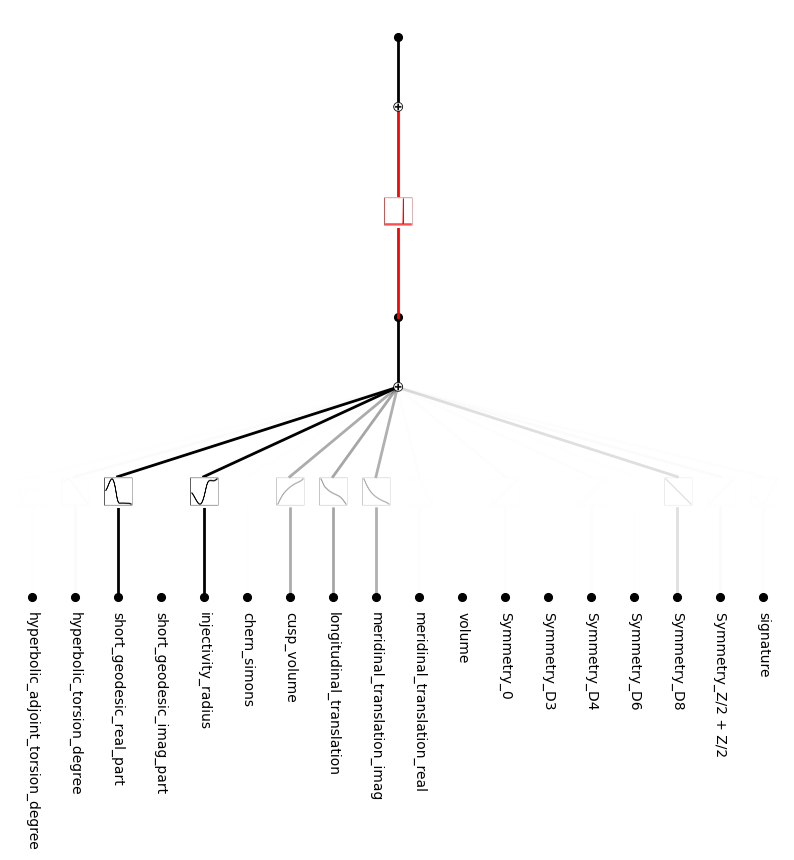

In [14]:
# seed = 2024
model.plot(scale=1.0)

n = 18
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,df.keys()[1:][i], rotation=270, rotation_mode="anchor")

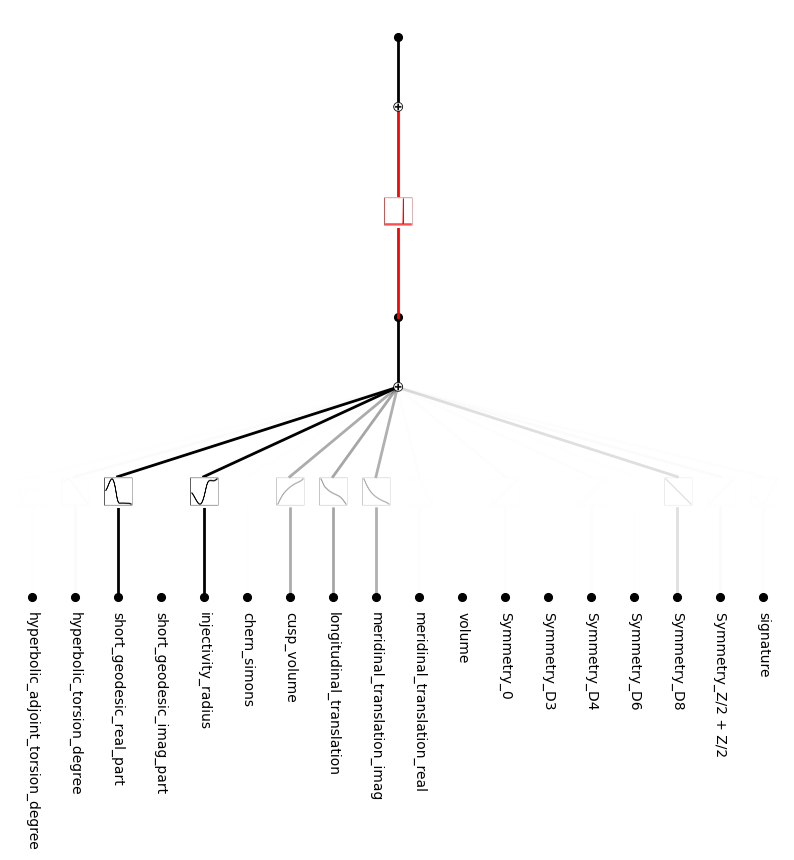

In [15]:
# seed = 0
model.plot(scale=1.0)

n = 18
for i in range(n):
    plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,df.keys()[1:][i], rotation=270, rotation_mode="anchor")

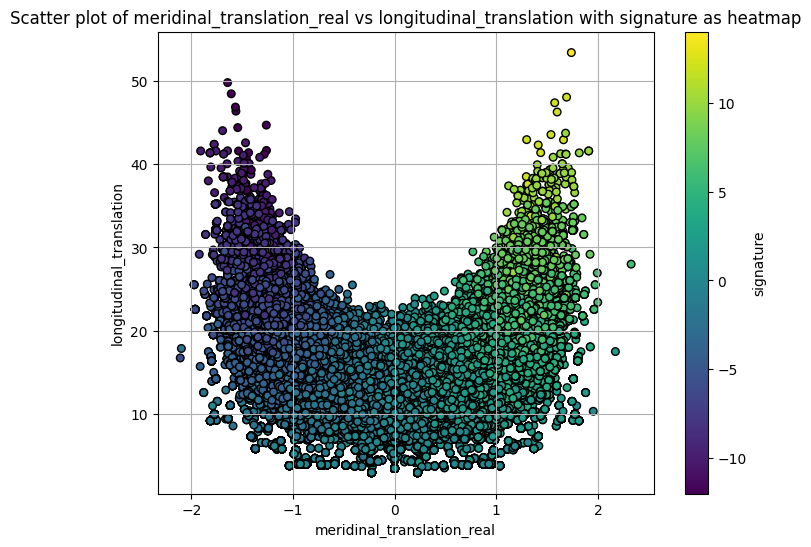

In [16]:
import matplotlib.pyplot as plt

x_col = 'meridinal_translation_real'
y_col = 'longitudinal_translation'
color_col = 'signature'

x = df[x_col]
y = df[y_col]
c = df[color_col]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=c, cmap='viridis', s=30, edgecolor='k')
plt.colorbar(scatter, label=color_col)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_col} vs {y_col} with {color_col} as heatmap')
plt.grid(True)
plt.show()

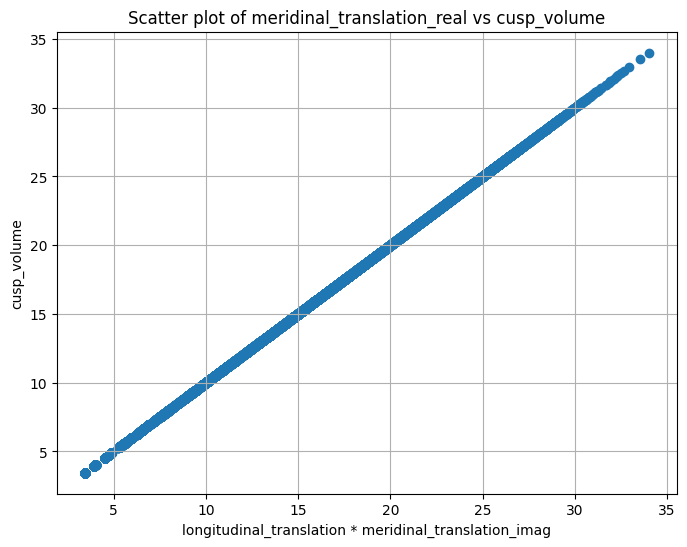

In [17]:
import matplotlib.pyplot as plt

y_col = 'cusp_volume'

x = df['longitudinal_translation'] * df['meridinal_translation_imag']
y = df[y_col]
c = df[color_col]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y)

plt.xlabel('longitudinal_translation * meridinal_translation_imag')
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_col} vs {y_col}')
plt.grid(True)
plt.show()

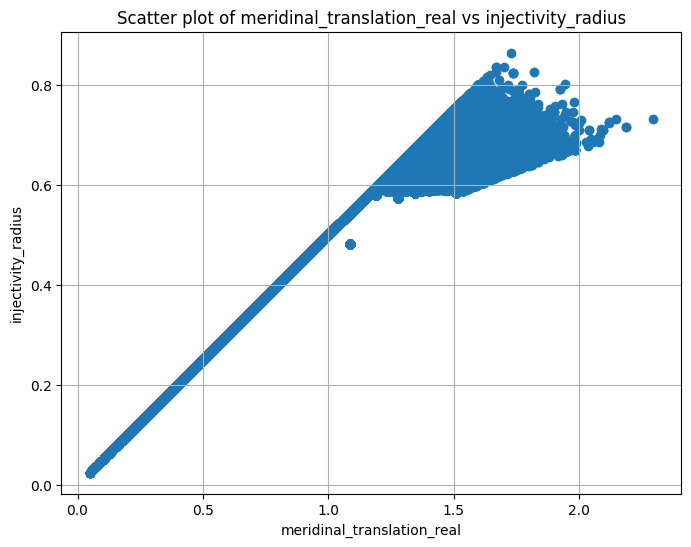

In [18]:
import matplotlib.pyplot as plt

y_col = 'injectivity_radius'

x = df['short_geodesic_real_part']
y = df[y_col]
c = df[color_col]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_col} vs {y_col}')
plt.grid(True)
plt.show()